# Statistical Analysis Project
---

**Goal**: Understand what are the variables that are more important in predicting realstate sales price.  
**Dataset**: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.multivariate.pca import PCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
data = pd.read_csv('train.csv')
data.shape

(1460, 81)

## 1. Data Wrangling
---

**Steps:**
- Dealing with missing values
- Feature reduction
- Data transformation

In [4]:
#getting rid of all the columns that have too many NaN

print(data.isna().sum().sort_values(ascending=False))
data.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'], 
          inplace=True)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageCond         81
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageQual         81
BsmtExposure       38
BsmtFinType2       38
BsmtFinType1       37
BsmtCond           37
BsmtQual           37
MasVnrArea          8
MasVnrType          8
Electrical          1
Utilities           0
YearRemodAdd        0
MSSubClass          0
Foundation          0
ExterCond           0
ExterQual           0
Exterior2nd         0
Exterior1st         0
RoofMatl            0
RoofStyle           0
YearBuilt           0
                 ... 
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
3SsnPorch           0
BsmtUnfSF           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
Functional          0
TotRmsAbvGrd        0
KitchenQua

In [5]:
#List of other variables that have a considerable number of NaN but I want to replace with something
data.isna().sum().sort_values(ascending=False)

con_na = ['GarageType', 
          'GarageYrBlt', 
          'GarageFinish', 
          'GarageCond', 
          'GarageQual', 
          'BsmtExposure', 
          'BsmtFinType2', 
          'BsmtFinType1', 
          'BsmtCond', 
          'BsmtQual']

#Removed GarageYrBlt from the list as it is the only numerical field, I will treat it differently
con_na.remove('GarageYrBlt')

In [6]:
#Fillna for all the variables in the list with 'NA'
data[con_na] = data[con_na].fillna('NA')
#Fillna for GarageYrBlt with 0
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(0)

In [7]:
#Filling other variables that have less NaN
print(data.isna().sum().sort_values(ascending=False))
data['MasVnrType'] = data['MasVnrType'].fillna('None')
data['MasVnrArea'] = data['MasVnrArea'].fillna(0.0)
data['Electrical'] = data['Electrical'].fillna('NA')

MasVnrType       8
MasVnrArea       8
Electrical       1
SalePrice        0
Foundation       0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
ExterQual        0
ExterCond        0
BsmtQual         0
TotalBsmtSF      0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
RoofStyle        0
YearRemodAdd     0
YearBuilt        0
OverallCond      0
MSSubClass       0
MSZoning         0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
                ..
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
GarageFinish     0
GarageYrBlt      0
GarageType       0
BsmtHalfBath     0
CentralAir       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
FullBath    

In [8]:
#Now we have no values missing
data.isna().sum().sort_values(ascending=False).head()

SalePrice       0
YearRemodAdd    0
RoofMatl        0
Exterior1st     0
Exterior2nd     0
dtype: int64

In [9]:
data.head()

Id  MSSubClass MSZoning  LotArea Street LotShape LandContour Utilities  \
0   1          60       RL     8450   Pave      Reg         Lvl    AllPub   
1   2          20       RL     9600   Pave      Reg         Lvl    AllPub   
2   3          60       RL    11250   Pave      IR1         Lvl    AllPub   
3   4          70       RL     9550   Pave      IR1         Lvl    AllPub   
4   5          60       RL    14260   Pave      IR1         Lvl    AllPub   

  LotConfig LandSlope  ... EnclosedPorch 3SsnPorch ScreenPorch PoolArea  \
0    Inside       Gtl  ...             0         0           0        0   
1       FR2       Gtl  ...             0         0           0        0   
2    Inside       Gtl  ...             0         0           0        0   
3    Corner       Gtl  ...           272         0           0        0   
4       FR2       Gtl  ...             0         0           0        0   

  MiscVal  MoSold  YrSold  SaleType  SaleCondition SalePrice  
0       0       2    2008        WD         Normal    208500  
1       0       5    2007        WD         Normal    181500  
2       0       9    2008        WD         Normal    223500  
3       0       2    2006        WD        Abnorml    140000  
4       0      12    2008        WD         Normal    250000  

[5 rows x 75 columns]

In [10]:
#Most of the properties have only one type of Porch, and we have 4 columns for the area of each
#Type of porch... So I will create a TotalPorchSF column with the sum of the other 4
#And drop the other for
data[['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].head(20)

OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch
0            61              0          0            0
1             0              0          0            0
2            42              0          0            0
3            35            272          0            0
4            84              0          0            0
5            30              0        320            0
6            57              0          0            0
7           204            228          0            0
8             0            205          0            0
9             4              0          0            0
10            0              0          0            0
11           21              0          0            0
12            0              0          0          176
13           33              0          0            0
14          213            176          0            0
15          112              0          0            0
16            0              0          0            0
17            0              0          0            0
18          102              0          0            0
19            0              0          0            0

In [11]:
data['TotalPorchSF'] = data['OpenPorchSF'] + data['EnclosedPorch'] + data['3SsnPorch'] + data['ScreenPorch']

In [12]:
data.drop(columns=['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], inplace=True)

In [13]:
#We have 4 columns that give us information about basement area:
#BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF
#The first 2 are the area of finished basement, the 3rd the area of unfinished basement
#And the 4th is the total.
#In order to have less columns, we will compute the % of finished basement area
#((BsmtFinSF1+BsmtFinSF2)/TotalBsmtSF)
#After that, we will eliminate BsmtFinSF1, BsmtFinSF2, BsmtUnfSF,

data['PercentBsmtFin'] = (data.BsmtFinSF1+data.BsmtFinSF2)/data.TotalBsmtSF
data.drop(columns=['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], inplace=True)

In [14]:
#we had 37 calculations that could not be made (the ones that have no basement)
#We will replace them with 0
data['PercentBsmtFin'].isna().sum()
data['PercentBsmtFin'] = data['PercentBsmtFin'].fillna(0)

In [15]:
#Now, we have 4 variables that describe the number of bathrooms in each property
#Though it gives us a lot of detail, we could have only one variable for that
data['TotalBath'] = data.BsmtFullBath + data.BsmtHalfBath + data.FullBath + data.HalfBath
data.drop(columns=['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], inplace=True)

In [16]:
#All columns that are categorical but have an implicit scale in it, 
#I will convert in only one column with a numerical scale

#First, let's separate those columns and check what is their scale
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition', 'SalePrice', 'TotalPorchSF',
       'PercentBsmtFin', 

In [17]:
#Categorical Variables that have an implicit scale
cat_scale = ['ExterQual', 
             'ExterCond', 
             'BsmtQual', 
             'BsmtCond', 
             'BsmtExposure', 
             'BsmtFinType1', 
             'BsmtFinType2', 
             'HeatingQC', 
             'Functional', 
             'GarageFinish', 
             'GarageQual', 
             'GarageCond']
data[cat_scale].head()

ExterQual ExterCond BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
0        Gd        TA       Gd       TA           No          GLQ   
1        TA        TA       Gd       TA           Gd          ALQ   
2        Gd        TA       Gd       TA           Mn          GLQ   
3        TA        TA       TA       Gd           No          ALQ   
4        Gd        TA       Gd       TA           Av          GLQ   

  BsmtFinType2 HeatingQC Functional GarageFinish GarageQual GarageCond  
0          Unf        Ex        Typ          RFn         TA         TA  
1          Unf        Ex        Typ          RFn         TA         TA  
2          Unf        Ex        Typ          RFn         TA         TA  
3          Unf        Gd        Typ          Unf         TA         TA  
4          Unf        Ex        Typ          RFn         TA         TA

In [18]:
cut_1 = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5} #'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'GarageQual', 'GarageCond'
cut_2 = {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6} #'BsmtFinType1', 'BsmtFinType2'
cut_3 = {'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4} #'BsmtExposure'
cut_4 = {'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7} #'Functional'
cut_5 = {'NA':0, 'Unf':1, 'RFn':2, 'Fin':3} #'GarageFinish'

def labeling(s, dic):
    return dic[s]

In [19]:
col_cut_1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'GarageQual', 'GarageCond']
col_cut_2 = ['BsmtFinType1', 'BsmtFinType2']

for el in col_cut_1:
    data[el] = data[el].apply(lambda x: labeling(x, cut_1))

for el in col_cut_2:
    data[el] = data[el].apply(lambda x: labeling(x, cut_2))

data['BsmtExposure'] = data['BsmtExposure'].apply(lambda x: labeling(x, cut_3))
data['Functional'] = data['Functional'].apply(lambda x: labeling(x, cut_4))
data['GarageFinish'] = data['GarageFinish'].apply(lambda x: labeling(x, cut_5))

In [20]:
data.drop(columns='Id', inplace=True)

In [21]:
data.head()

MSSubClass MSZoning  LotArea Street LotShape LandContour Utilities  \
0          60       RL     8450   Pave      Reg         Lvl    AllPub   
1          20       RL     9600   Pave      Reg         Lvl    AllPub   
2          60       RL    11250   Pave      IR1         Lvl    AllPub   
3          70       RL     9550   Pave      IR1         Lvl    AllPub   
4          60       RL    14260   Pave      IR1         Lvl    AllPub   

  LotConfig LandSlope Neighborhood  ... PoolArea MiscVal MoSold YrSold  \
0    Inside       Gtl      CollgCr  ...        0       0      2   2008   
1       FR2       Gtl      Veenker  ...        0       0      5   2007   
2    Inside       Gtl      CollgCr  ...        0       0      9   2008   
3    Corner       Gtl      Crawfor  ...        0       0      2   2006   
4       FR2       Gtl      NoRidge  ...        0       0     12   2008   

   SaleType  SaleCondition  SalePrice  TotalPorchSF PercentBsmtFin TotalBath  
0        WD         Normal     208500            61       0.824766         4  
1        WD         Normal     181500             0       0.774960         3  
2        WD         Normal     223500            42       0.528261         4  
3        WD        Abnorml     140000           307       0.285714         2  
4        WD         Normal     250000            84       0.572052         4  

[5 rows x 66 columns]

## 2. Correlation

**Steps:**
- Initial Correlation Matrix
- Dealing with categorical data
- Mapping correlations and new feature reduction
- Final Correlation Matrix
- Most Correlated Features

In [22]:
corr = data.corr()

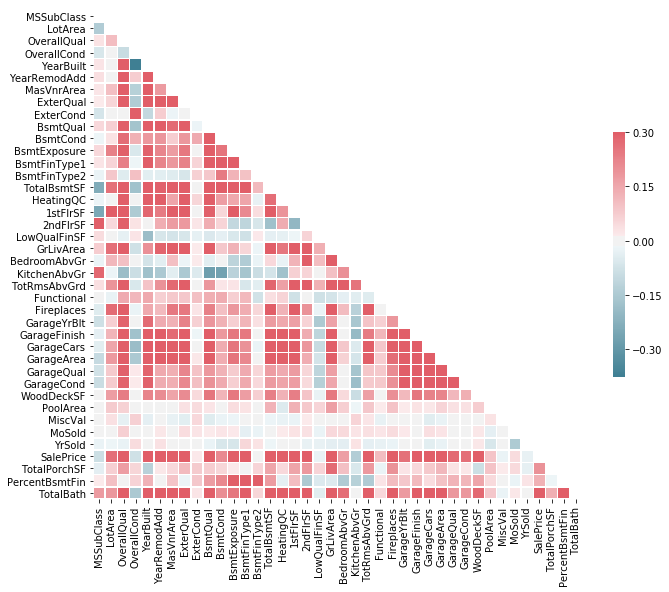

In [23]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [24]:
#According to our correlation matrix, there are a lot of variables that are not relevant
#To determining a property's price:
#MSSubClass, OverallCond, ExterCond, BsmntFinType2, LowQualFinSF, MiscVal, MoSold, YrSold
#BedroomAbvGr, KitchenAbvGr, Functional, PoolArea, TotalPorchSF, PercentBsmntFin
corr['SalePrice']

MSSubClass       -0.084284
LotArea           0.263843
OverallQual       0.790982
OverallCond      -0.077856
YearBuilt         0.522897
YearRemodAdd      0.507101
MasVnrArea        0.472614
ExterQual         0.682639
ExterCond         0.018899
BsmtQual          0.585207
BsmtCond          0.212607
BsmtExposure      0.374696
BsmtFinType1      0.304908
BsmtFinType2     -0.005323
TotalBsmtSF       0.613581
HeatingQC         0.427649
1stFlrSF          0.605852
2ndFlrSF          0.319334
LowQualFinSF     -0.025606
GrLivArea         0.708624
BedroomAbvGr      0.168213
KitchenAbvGr     -0.135907
TotRmsAbvGrd      0.533723
Functional        0.107619
Fireplaces        0.466929
GarageYrBlt       0.261366
GarageFinish      0.549247
GarageCars        0.640409
GarageArea        0.623431
GarageQual        0.273839
GarageCond        0.263191
WoodDeckSF        0.324413
PoolArea          0.092404
MiscVal          -0.021190
MoSold            0.046432
YrSold           -0.028923
SalePrice         1.000000
T

In [25]:
#We are dropping all columns that have a correlation between -0.2 and +0.2
no_corr = ['MSSubClass', 
           'OverallCond', 
           'ExterCond', 
           'BsmtFinType2', 
           'LowQualFinSF', 
           'MiscVal', 
           'MoSold', 
           'YrSold', 
           'BedroomAbvGr', 
           'KitchenAbvGr', 
           'Functional', 
           'PoolArea', 
           'TotalPorchSF', 
           'PercentBsmtFin']

data.drop(columns=no_corr, inplace=True)

In [26]:
#Now, we are left with 52 columns
#There are still a lot of columns, so let's also take away all variables that have a corr between
#-0.3 and +0.3, so we have a more precise method
corr = data.corr()

In [27]:
corr['SalePrice']

LotArea         0.263843
OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
ExterQual       0.682639
BsmtQual        0.585207
BsmtCond        0.212607
BsmtExposure    0.374696
BsmtFinType1    0.304908
TotalBsmtSF     0.613581
HeatingQC       0.427649
1stFlrSF        0.605852
2ndFlrSF        0.319334
GrLivArea       0.708624
TotRmsAbvGrd    0.533723
Fireplaces      0.466929
GarageYrBlt     0.261366
GarageFinish    0.549247
GarageCars      0.640409
GarageArea      0.623431
GarageQual      0.273839
GarageCond      0.263191
WoodDeckSF      0.324413
SalePrice       1.000000
TotalBath       0.613005
Name: SalePrice, dtype: float64

In [28]:
data.drop(columns=['LotArea', 'BsmtCond', 'GarageYrBlt', 'GarageQual', 'GarageCond'], inplace=True)

In [29]:
data.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure',
       'BsmtFinType1', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageFinish',
       'GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF', 'SaleType',
       'SaleCondition', 'SalePrice', 'TotalBath'],
      dtype='object')

In [30]:
#Before we proceed to creating the dummies, let's check the variability of the remaining
#categorical variables
#Just in a first look, there are 8 variables that have almost no variabilty. We will eliminate them.
print(data['Street'].value_counts())
print(data['Condition1'].value_counts())
print(data['Utilities'].value_counts())
print(data['Condition2'].value_counts())
print(data['RoofMatl'].value_counts())
print(data['Heating'].value_counts())
print(data['CentralAir'].value_counts())
print(data['Electrical'].value_counts())
print(data['PavedDrive'].value_counts())

Pave    1454
Grvl       6
Name: Street, dtype: int64
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
Norm      1445
Feedr        6
Artery       2
PosN         2
RRNn         2
RRAn         1
PosA         1
RRAe         1
Name: Condition2, dtype: int64
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Membran       1
Roll          1
Metal         1
ClyTile       1
Name: RoofMatl, dtype: int64
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64
Y    1365
N      95
Name: CentralAir, dtype: int64
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
NA          1
Mix         1
Name: Electrical, dtype: int64
Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64


In [31]:
equals = ['Street', 'Condition1', 'Condition2', 'RoofMatl', 
          'Heating', 'CentralAir', 'Electrical', 'PavedDrive', 'Utilities']

#Applied labeling function to KitchenQual, as I noticed I forgot to include it in my previous run
data['KitchenQual'] = data['KitchenQual'].apply(lambda x: labeling(x, cut_1))
data.drop(columns=equals, inplace=True)

In [32]:
#After all this process, we are left with 38 columns out of the 80 we started with.
#It is good, but we still have not finished cleaning the dataset!
#There are still 17 categorical variables that have had no treatment
#Since they do not imply a scale, the best would be to use the method get_dummies
#So that every category will become a binary variable
data.shape

(1460, 38)

In [33]:
data = pd.get_dummies(data)

In [34]:
#Now we have 150 columns!!
data.shape

(1460, 150)

In [35]:
#Creating a Dictionary with all the correlations in the dataframe, against the 'SalePrice' column
columnas = list(data.columns)
correlaciones = {}
for el in columnas:
    if el != 'SalePrice':
        correlaciones[el] = data[['SalePrice', el]].corr()['SalePrice'][el]
        
correlaciones

{'OverallQual': 0.7909816005838047,
 'YearBuilt': 0.5228973328794967,
 'YearRemodAdd': 0.5071009671113867,
 'MasVnrArea': 0.47261449900457725,
 'ExterQual': 0.6826392416562591,
 'BsmtQual': 0.5852071991725148,
 'BsmtExposure': 0.3746962210008844,
 'BsmtFinType1': 0.3049078730706334,
 'TotalBsmtSF': 0.6135805515591944,
 'HeatingQC': 0.4276487073988049,
 '1stFlrSF': 0.6058521846919166,
 '2ndFlrSF': 0.31933380283206614,
 'GrLivArea': 0.7086244776126511,
 'KitchenQual': 0.6595997207286572,
 'TotRmsAbvGrd': 0.5337231555820238,
 'Fireplaces': 0.4669288367515242,
 'GarageFinish': 0.5492467563332154,
 'GarageCars': 0.640409197258349,
 'GarageArea': 0.6234314389183598,
 'WoodDeckSF': 0.32441344456813076,
 'TotalBath': 0.6130046086468899,
 'MSZoning_C (all)': -0.11125658290808499,
 'MSZoning_FV': 0.08994971967036147,
 'MSZoning_RH': -0.06542929310102559,
 'MSZoning_RL': 0.24506340389709183,
 'MSZoning_RM': -0.2880651218971229,
 'LotShape_IR1': 0.22328392470489936,
 'LotShape_IR2': 0.126096088203

In [36]:
#Now, for every column in the dataframe, if the correlation is between 0.3 and -0.3,
#we will eliminate the column

for el in columnas:
    if el != 'SalePrice' and correlaciones[el] < 0.3 and correlaciones[el] > -0.3:
        data.drop(columns=el, inplace=True)

In [37]:
#Now we are back to having 34 columns!! Yay! :D
data.shape

(1460, 34)

In [38]:
#We can see that in the columns we have left there is a mix of parts of 
#most original variables we had in the first place, but only the ones that impact the sale price
#in some way
data.columns

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual',
       'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'TotalBsmtSF', 'HeatingQC',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'KitchenQual', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageFinish', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'SalePrice', 'TotalBath', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Exterior1st_VinylSd', 'Exterior2nd_VinylSd',
       'MasVnrType_None', 'MasVnrType_Stone', 'Foundation_CBlock',
       'Foundation_PConc', 'GarageType_Attchd', 'GarageType_Detchd',
       'SaleType_New', 'SaleCondition_Partial'],
      dtype='object')

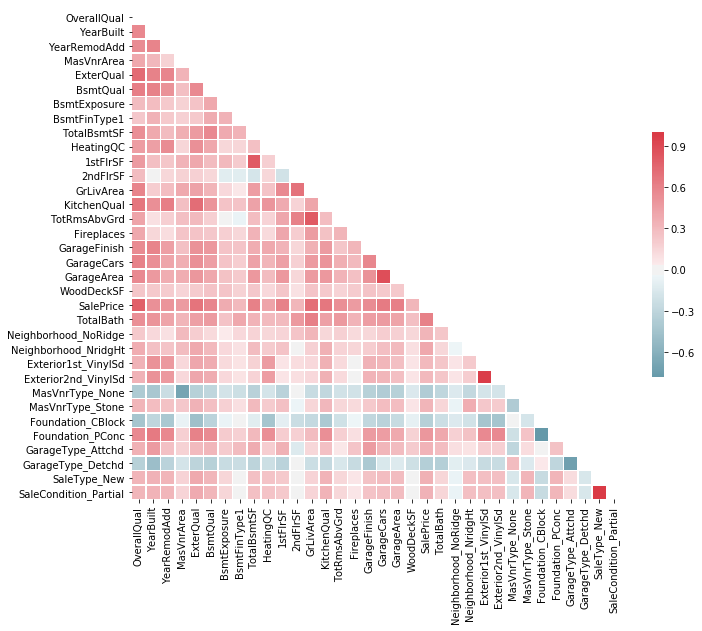

In [39]:
#Let's make a new visualization to see this partial result
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [40]:
#Much better! Now we are only missing 1 step before we can reduce dimensions
#We have two variables with years (YearBuilt and YearRemodAdd). 
#Since we will not do timeseries analysis, let's transform the variables to get the number of
#years insted of the exact 4-digit year

data['YearBuilt'] = 2019 - data['YearBuilt']
data['YearRemodAdd'] = 2019 - data['YearRemodAdd']

In [41]:
#Let's check what are the variables that are most related to SalePrice and plot them
corr['SalePrice'].sort_values(ascending=False).head(11)[1:]

OverallQual    0.790982
GrLivArea      0.708624
ExterQual      0.682639
KitchenQual    0.659600
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
TotalBath      0.613005
1stFlrSF       0.605852
BsmtQual       0.585207
Name: SalePrice, dtype: float64

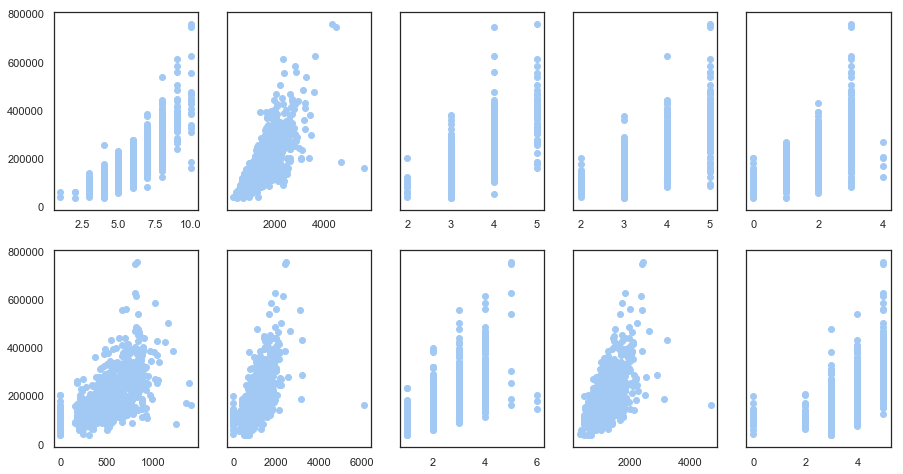

In [42]:
sns.set(style='white', palette='pastel', rc={'figure.figsize':(15,8)})

f, [[ax1, ax2, ax3, ax4, ax5], [ax6, ax7, ax8, ax9, ax10]] = plt.subplots(2,5, sharey=True)

ax1.scatter(data.OverallQual, data.SalePrice)
ax2.scatter(data.GrLivArea, data.SalePrice)
ax3.scatter(data.ExterQual, data.SalePrice)
ax4.scatter(data.KitchenQual, data.SalePrice)
ax5.scatter(data.GarageCars, data.SalePrice)

ax6.scatter(data.GarageArea, data.SalePrice)
ax7.scatter(data.TotalBsmtSF, data.SalePrice)
ax8.scatter(data.TotalBath, data.SalePrice)
ax9.scatter(data['1stFlrSF'], data.SalePrice)
ax10.scatter(data.BsmtQual, data.SalePrice)

## 3. Regression and PCA

**Steps**
- Regression with all features
- PCA
- Regression with PCA factors
- Regression with less features

In [43]:
#We will now practice our regression skills
#Let's split the data, removing the SalePrice
X = data.drop(columns='SalePrice')
y = data['SalePrice']

In [45]:
#Let me test first how my model works for my data as is
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
linreg = LinearRegression()
linreg.fit(X_train, y_train)

#Not bad but also not optimum... I have an R^2 of 0.86 for the test sample
#Let's try reducing the dimensions to see if we have better results
print(linreg.score(X_train, y_train))
print(linreg.score(X_test, y_test))

0.8151734707537033
0.8610896255936294


In [46]:
#Very high MSE!
y_hat = linreg.predict(X_test)
mean_squared_error(y_test, y_hat)

973110103.2927918

In [72]:
#Reducing to 10 components makes us still have 80% of the information
X_reduced = PCA(X, ncomp=12)
X_reduced.rsquare

ncomp
0     0.000000
1     0.328996
2     0.418202
3     0.495055
4     0.554719
5     0.595492
6     0.634697
7     0.668655
8     0.700228
9     0.729911
10    0.758595
11    0.784291
12    0.806045
Name: rsquare, dtype: float64

In [73]:
#Let's bring the factors to a dataframe, so we can use them in our regression
X_components = X_reduced.factors
X_components.columns

Index(['comp_00', 'comp_01', 'comp_02', 'comp_03', 'comp_04', 'comp_05',
       'comp_06', 'comp_07', 'comp_08', 'comp_09', 'comp_10', 'comp_11'],
      dtype='object')

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_components, y, random_state=42)

In [75]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [76]:
#The results do not vary based on the PCA
#PCA gives us better performance without losing on the results
print(linreg.score(X_train, y_train))
print(linreg.score(X_test, y_test))

0.7942917244606398
0.8407442470289663


In [77]:
#Now let's compute our mean squared error
y_hat = linreg.predict(X_test)

#It is super high, we must have over-fitting :(
mean_squared_error(y_test, y_hat)

1115635767.9250965

In [78]:
#As a last try, what if we try regression only with those variables that are highly correlated
#to SalePrice?
high_corr = list(corr['SalePrice'].sort_values(ascending=False).head(15)[1:].index)
X_high = data[high_corr]

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_high, y, random_state=42)

In [80]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [81]:
#If I take off variables directly I lose more than performing a PCA with all the variables.
print(linreg.score(X_train, y_train))
print(linreg.score(X_test, y_test))

0.779924121189908
0.8168248304704792


In [82]:
#Also very large MSE
y_hat = linreg.predict(X_test)
mean_squared_error(y_test, y_hat)

1283198673.2689424